# Predict ages using linear regression

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df1 = pd.read_pickle('Mc_Gar_Sant')

Calculate ages.

In [24]:
from stardate.lhf import age_model
ages = []
for i in range(len(df1)):
    bprp = df1.phot_bp_mean_mag.values[i] - df1.phot_rp_mean_mag.values[i]
    log10_period = np.log10(df1.Prot.values[i])
    log10_age_yrs = age_model(log10_period, bprp)
    age_gyr = (10**log10_age_yrs)*1e-9
    ages.append(age_gyr)

ages = np.array(ages)
df1["true_age"] = ages

# Add realistic noise (20% uncertainties).
noise = np.random.randn(len(ages))*(.2*ages)
ages += noise
df1["age"] = ages

(0, 8)

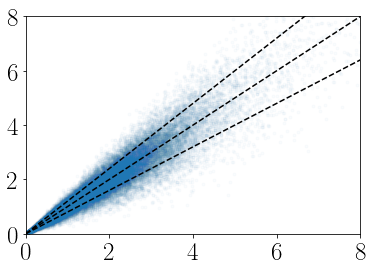

In [25]:
plt.plot(df1.true_age, df1.age, ".", alpha=.02)
xs = np.linspace(0, 8, 100)
plt.plot(xs, xs, "k--")
plt.plot(xs, xs*.8, "k--")
plt.plot(xs, xs*1.2, "k--")
plt.xlim(0, 8)
plt.ylim(0, 8)

Calculate Ro.

In [26]:
from stardate.lhf import convective_overturn_time

tau = convective_overturn_time(df1["Mass"])
Ro = df1["Prot"]/tau
df1["Ro"] = Ro

Calculate magnitudes

In [27]:
def abs_mag(m, D):
    """
    m - M = 5log(D) - 5
    M = m - 5log(D) + 5
    """
    return m - 5*np.log10(D) + 5

abs_G = abs_mag(df1.phot_g_mean_mag.values, 1./df1.parallax.values)
df1["abs_G"] = abs_G
df1["bprp"] = df1.phot_bp_mean_mag.values - df1.phot_rp_mean_mag.values

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


Mask Nans and remove extreme Teffs and Prots.

In [28]:
features = [df1["Rper"], df1["teff"], df1["bp_g"], df1["loglum_val"], df1["phot_g_mean_flux_over_error"],
            df1["radius_val"], df1["v_tan"], df1["v_b"], df1["b"], df1["age"]]

m = np.isfinite(df1["Rper"].values) * (df1["Rper"].values !=0)
for f in features[1:]:
    m &= np.isfinite(f.values) * (f.values != 0)
    
df = df1.iloc[m]
print(np.shape(df), np.shape(df1))

# Also, do a temperature and prot cut
m = (df.teff.values < 6000) * (df.teff.values > 3500)
m &= (df.Prot.values > 10)

# Do a rossby number cut.
m &= df.Ro.values > 1

df = df.iloc[m]
print(np.shape(df))

(34997, 175) (38573, 175)
(12139, 175)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


Define training data and feature set.

In [34]:
y = df.age.values

X = np.vstack((df["Rper"], df["bprp"],# df["Prot"],
                  df["abs_G"])).T
print(np.shape(X), np.shape(y))

(12139, 3) (12139,)


Shuffle indices to create training and test set.

In [35]:
# Define the number of training and validating stars.
Ntrain = 6000

# Choose stars at random and split.
shuffle_inds = np.arange(len(y))
np.random.shuffle(shuffle_inds)
train_inds = shuffle_inds[:Ntrain]
test_inds = shuffle_inds[Ntrain:]
y_train, X_train = y[train_inds], X[train_inds, :]
y_test, X_test = y[test_inds], X[test_inds, :]

Train the random forest.

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

np.random.seed(42)
regr = RandomForestRegressor(n_estimators=7)

regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=7, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Calculate summary statistics.

In [37]:
def rms(y):
    return np.sqrt(np.mean(y**2))

x1, x2 = y_test, regr.predict(X_test)
print("RMS = ", rms(x1 - x2), "Gyr")
err = y_test - regr.predict(X_test)

rerr = abs(err)/y_test
percentage_err = rerr*100
print("median relative error = ", np.median(rerr)*100, "%")

RMS =  1.2537616859340983 Gyr
median relative error =  22.903652080643848 %


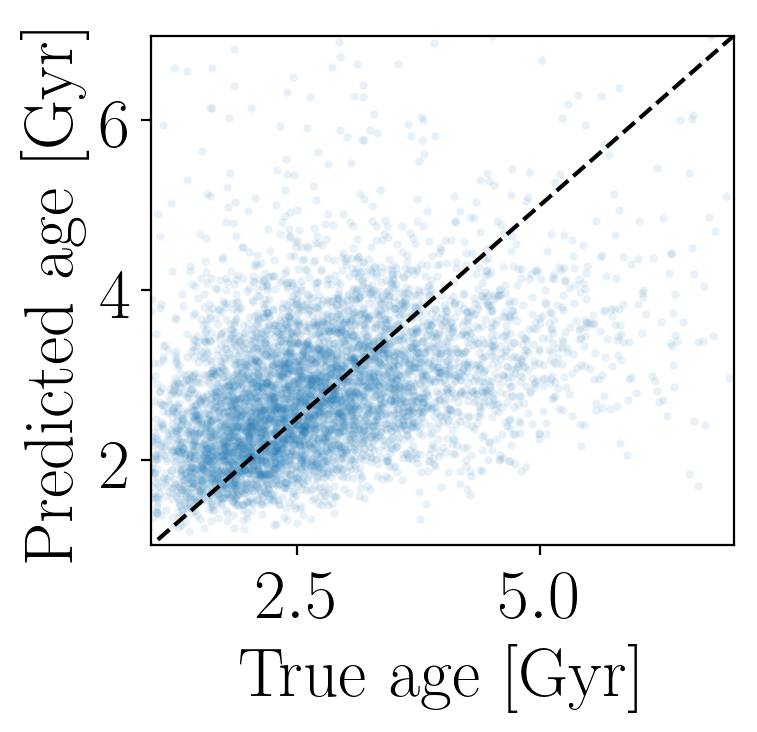

In [39]:
plotpar = {'axes.labelsize': 25,
           'font.size': 20,
           'legend.fontsize': 25,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

plt.figure(figsize=(7, 4), dpi=200)
plt.ylabel("$\mathrm{Predicted~age~[Gyr]}$")
plt.tight_layout()

plt.subplot(1, 2, 2)
xs = np.linspace(y_test.min(), y_test.max(), 100)
plt.plot(y_test, regr.predict(X_test), ".", mec="none", alpha=.1)
plt.plot(xs, xs, "k--")
plt.xlim(1, 7)
plt.ylim(1, 7)
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.tight_layout()
plt.ylabel("$\mathrm{Predicted~age~[Gyr]}$")
plt.savefig("take_2")

Rvar only: 15% uncertainty on ages without noise.
           20% uncertainty on ages with 10% noise.
           
Prot: 0.5% uncertainty on ages without noise.
      10% uncertainty on ages with 10% noise.